<a href="https://colab.research.google.com/github/Douglas5040/Redes-Neurais-USP/blob/main/Artigo-Xingu/LSTM_Rio_Xingu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.6.9


In [ ]:
!pip install seaborn

In [33]:
# prepare data for lstm
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
import numpy as np
from numpy import concatenate
from pandas import concat
import seaborn as sns
from math import sqrt
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Dropout, Flatten, GRU
from tensorflow import keras
from datetime import datetime

Download do dataset do rio xingu

In [34]:
dataset_path = keras.utils.get_file("dataset-river-xingu.data", "https://drive.google.com/u/0/uc?id=1xDJ-aLbcpFX2vdHEIvUc2KwbhQXUWSzs&export=download")
dataset_path

'/root/.keras/datasets/dataset-river-xingu.data'

Carregandos dados do rio xingu. Os dados são referente aos parametros hidrograficos, de acordo com a variavel column_names.

A primeira coluna é transformada no indice do dataset e convertida em data, deixando assim o dataset com uma serie temporal

In [35]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m')

column_names = ['data','maxima','nino1_2','nino3','nino4',
                'nino3_4', 'altantico_norte', 'altantico_sul', 
                'atlantico_tropical','pressao_darwin','pressao_tahiti',
                'prp_xingu-al01','prp_xingu-al02','prp_xingu-al03',
                'prp_xingu-al04','prp_xingu-al05','prp_xingu-al06',
                'prp_xingu-al07','prp_xingu-al08','prp_xingu-al09']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          parse_dates = [0], index_col=0, date_parser=parse,
                      na_values = "?", comment='#', encoding='UTF-8',
                      sep=";", skipinitialspace=True)
#print(raw_dataset.head(5))
dataset = raw_dataset.copy()
dataset

,maxima,nino1_2,nino3,nino4,nino3_4,altantico_norte,altantico_sul,atlantico_tropical,pressao_darwin,pressao_tahiti,prp_xingu-al01,prp_xingu-al02,prp_xingu-al03,prp_xingu-al04,prp_xingu-al05,prp_xingu-al06,prp_xingu-al07,prp_xingu-al08,prp_xingu-al09
data,,,,,,,,,,,,,,,,,,,
1979-01-01,560.0,24.97,25.39,28.38,26.48,25.95,25.31,27.51,1006.0,1009.6,471.6,430.1,392.9,353.6,451.1,342.7,415.3,286.9,292.9
1979-02-01,750.0,25.74,26.17,28.21,26.59,25.72,26.10,27.70,1006.9,1012.9,338.0,322.9,301.3,379.2,404.4,395.2,205.8,379.5,325.2
1979-03-01,776.0,26.07,27.27,28.27,27.41,25.67,26.48,28.15,1007.9,1011.3,216.9,181.5,142.9,177.0,197.5,264.8,160.6,203.2,231.8
1979-04-01,753.0,25.63,27.76,28.51,27.93,26.16,26.66,28.47,1009.7,1011.4,75.2,92.9,105.3,116.4,160.1,151.6,207.5,158.7,150.4
1979-05-01,583.0,24.52,27.34,28.76,27.88,26.65,25.92,28.32,1011.2,1013.3,56.2,54.5,24.0,33.1,46.5,85.5,70.2,118.4,152.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,324.0,22.03,25.41,29.11,26.90,27.54,23.05,27.45,1014.5,1014.4,0.1,0.7,0.1,1.5,3.0,16.6,2.9,27.7,69.0
2014-09-01,278.0,21.47,25.36,29.24,27.03,28.22,22.99,27.50,1013.1,1014.2,42.3,26.6,39.3,29.5,59.5,46.0,72.8,80.5,55.2
2014-10-01,NaN,21.66,25.72,29.28,27.25,28.38,23.34,27.79,1011.6,1013.2,28.2,24.2,40.2,51.4,133.6,101.2,207.0,215.5,81.7


Verifica se o dataset tem algum valor NULO, ou Não Identificado (NaN) e após a analise a funçao dropona remove a linha com essa caracteristica

In [36]:
dataset = dataset.dropna()
dataset.tail()

,maxima,nino1_2,nino3,nino4,nino3_4,altantico_norte,altantico_sul,atlantico_tropical,pressao_darwin,pressao_tahiti,prp_xingu-al01,prp_xingu-al02,prp_xingu-al03,prp_xingu-al04,prp_xingu-al05,prp_xingu-al06,prp_xingu-al07,prp_xingu-al08,prp_xingu-al09
data,,,,,,,,,,,,,,,,,,,
2014-07-01,399.0,23.12,26.30,29.05,27.28,26.91,23.79,27.70,1013.9,1014.4,4.3,1.6,3.2,2.0,1.0,6.3,0.2,4.3,16.9
2014-08-01,324.0,22.03,25.41,29.11,26.90,27.54,23.05,27.45,1014.5,1014.4,0.1,0.7,0.1,1.5,3.0,16.6,2.9,27.7,69.0
2014-09-01,278.0,21.47,25.36,29.24,27.03,28.22,22.99,27.50,1013.1,1014.2,42.3,26.6,39.3,29.5,59.5,46.0,72.8,80.5,55.2
2014-11-01,320.0,22.39,26.03,29.37,27.52,27.73,23.52,27.97,1009.9,1011.3,117.5,59.4,142.0,100.6,170.4,156.5,200.5,219.9,141.2
2014-12-01,447.0,23.36,26.07,29.33,27.40,26.84,24.35,27.95,1007.5,1009.9,222.7,96.2,263.8,161.6,203.5,139.8,176.4,88.9,38.1


Aqui podemos visualizar graficamente algumas series temporais com 420 meses do dataset

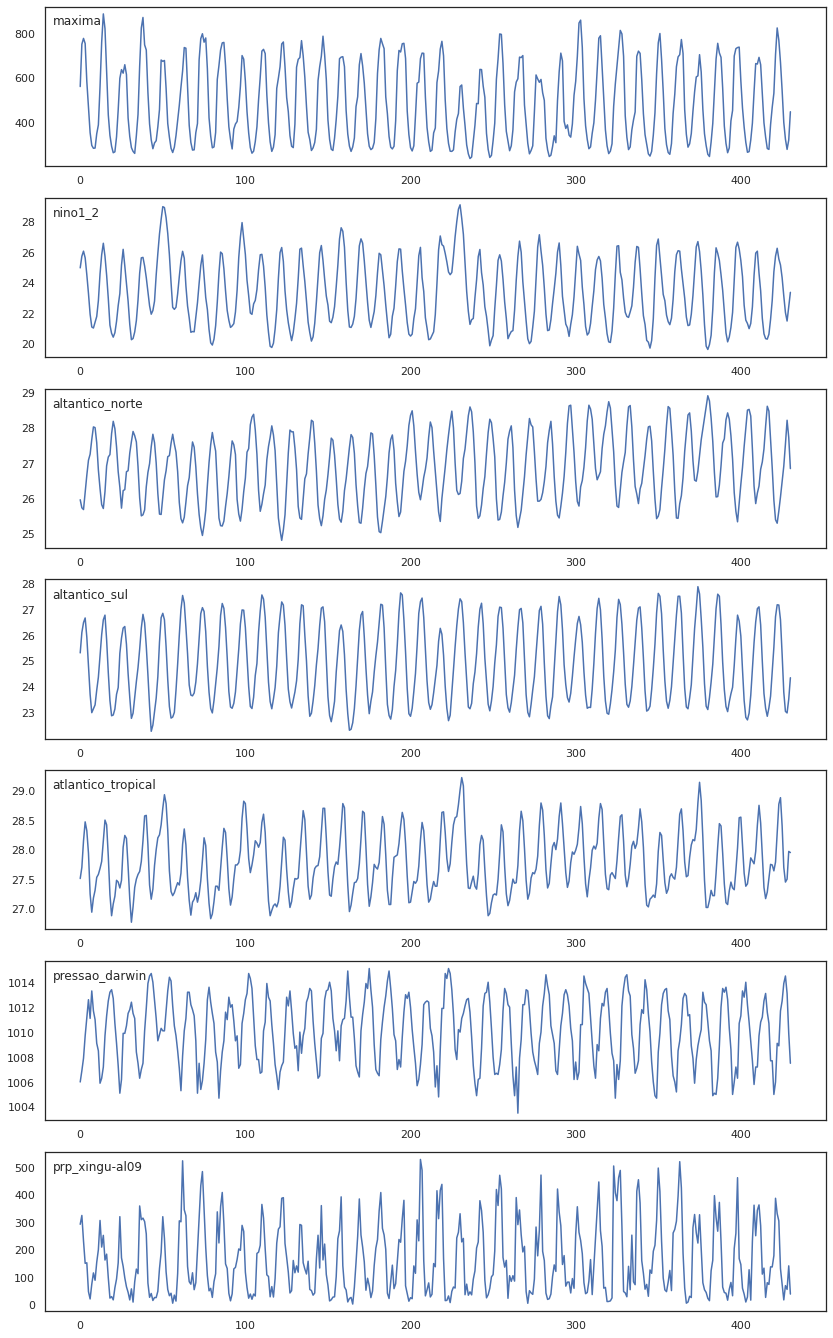

In [58]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 5, 6, 7, 8,18]
i = 1
# plot each column
f = plt.figure(figsize=(14,24))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.85, x=0.01, loc='left')
	i += 1
plt.show()

#f.savefig("graph_dataset.png")

## Execute modelo

Separando os dados para testes

In [ ]:
dataset_select = dataset

label_teste_data = dataset_select[-70:]['maxima']
label_teste_data

Inicializando variavel para receber os dados previsto no modelo

In [ ]:
label_predict_data = dataset[-70:]['maxima'].apply(lambda x: 0.0)
label_predict_data

Função do aprendizado supervisionado com defasagem

In [61]:
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Normalização dos dados

In [62]:

# load dataset
values = dataset_select.values

#Croio uma variavel para receber os valores normalizado e dafasados
values = values.astype('float32')

#Normalização com o Sklearnig
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# # frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#seleciono somente as colunas de variaveis que irei prever
reframed.drop(reframed.columns[20:], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var1(t)
1,0.497689,0.564075,0.313725,0.513072,0.388372,0.280872,0.542039,0.302041,0.215515,0.237617,0.749762,0.720315,0.687249,0.611342,0.873040,0.677953,0.846860,0.564760,0.551515,0.790447
2,0.790447,0.644958,0.452763,0.457517,0.413953,0.225181,0.683363,0.379593,0.293106,0.564362,0.537361,0.540780,0.527025,0.655602,0.782659,0.782513,0.419657,0.748709,0.612689,0.830509
3,0.830509,0.679622,0.648841,0.477125,0.604651,0.213075,0.751341,0.563266,0.379311,0.405937,0.344833,0.303969,0.249956,0.306017,0.382233,0.522804,0.327488,0.398490,0.435795,0.795069
4,0.795069,0.633403,0.736186,0.555556,0.725581,0.331719,0.783542,0.693878,0.534485,0.415840,0.119555,0.155585,0.184188,0.201245,0.309851,0.297351,0.423124,0.310091,0.281629,0.533128
5,0.533128,0.516807,0.661319,0.637256,0.713953,0.450363,0.651163,0.632653,0.663795,0.603958,0.089348,0.091274,0.041980,0.057227,0.089994,0.165704,0.143148,0.230036,0.285417,0.349769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.469954,0.495798,0.620321,0.732026,0.667442,0.406779,0.531306,0.665306,0.775864,0.623764,0.008108,0.035170,0.000350,0.007780,0.009483,0.036049,0.013254,0.073699,0.133902,0.249615
427,0.249615,0.369748,0.475936,0.732026,0.574419,0.513317,0.270125,0.379593,0.896553,0.712875,0.006836,0.002680,0.005597,0.003458,0.001935,0.007967,0.000408,0.003377,0.028788,0.134052
428,0.134052,0.255252,0.317291,0.751635,0.486046,0.665860,0.137746,0.277552,0.948273,0.712875,0.000159,0.001172,0.000175,0.002593,0.005806,0.028480,0.005914,0.049861,0.127462,0.063174
429,0.063174,0.196429,0.308378,0.794118,0.516279,0.830508,0.127012,0.297959,0.827583,0.693069,0.067250,0.044549,0.068742,0.051003,0.115154,0.087034,0.148450,0.154748,0.101326,0.127889


## Modelo LSTM

Aqui iremos dividir o Dataset em **70** meses para ***testes*** e **350** meses para ***treino***, logo em seguido iremos setar o shape para nosso modelo.

In [63]:
def set_shape_data():
  # split into train and test sets
  values = reframed.values
  #o conjunto de dados tem 35 anos dividido em meses, vamos usar 30 anos para treino e 5 para testes
  n_train_mes = 12 * 30
  train = values[:n_train_mes, :]
  test = values[n_train_mes:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
  return  train_X, train_y, test_X, test_y

Função que configura a topologia do nosso modelo com duas camadas LSTM

In [73]:
def set_model(neuronios_entrada=5, neuronios_in_layer_1=40, train_X=None):
  
  model = Sequential()

  model.add(LSTM(neuronios_in_layer_1, activation="relu", input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True ))
  model.add(LSTM(neuronios_entrada, return_sequences=True))
  model.add(Dense(1))

  model.summary()
  return model


Compilaçao do modelo acima

In [66]:
def compile_model(model, epocas):
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(train_X, train_y, epochs=epocas, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  mae = model.evaluate(test_X, test_y)
  #plot history
  plt.figure(figsize=(10,8))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  return mae

# Previsões

transformando escala do dataset

In [68]:
# make a prediction
def invert_scale(model, test_y, test_X):
  yhat = model.predict(test_X)
  yhat = yhat.reshape(( test_X.shape[0], test_X.shape[1]))
  # print(yhat.shape)
  # print(yhat)
  test_X = test_X.reshape(( test_X.shape[0], test_X.shape[2]))
  # print(test_X.shape)
  # print(test_X)
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # # calculate RMSE
  return inv_y, inv_yhat



Metrica RMSE

In [17]:
def get_rmse(inv_y, inv_yhat):  
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  return rmse

Calculo da acuracia do meu modelo atraves da metrica R2

In [18]:
def get_r2(inv_y, inv_yhat):
  r2 = r2_score(y_pred=inv_yhat.reshape(-1,1), y_true=inv_y.reshape(-1,1))
  return r2

In [69]:
def plot_graph_prev(name='rnn_prev',inv_yhat=None):
  
  label_teste_data = dataset_select[-70:]['maxima']
  label_teste_data

  label_predict_data = dataset[-70:]['maxima'].apply(lambda x: 0.0)
  label_predict_data

  for i in range(0, inv_yhat.size):
    label_predict_data[i] = inv_yhat[i]
    
  f = plt.figure(figsize=(10,7))
  plt.plot(label_teste_data, label="Real")
  plt.plot(label_predict_data, color="red", label="Prevista")
  plt.xticks(rotation=40)
  plt.ylabel("Maxima (qtd)")
  plt.xlabel("Tempo")
  plt.legend(loc="best")
  f.savefig(name+".pdf")
  plt.show()

In [ ]:
SAIDAS_METRICAS = {'round': [], 'r2': [], 'mae': [], 'rmse': [], 'Number of neurons': []}
df = pd.DataFrame(data=SAIDAS_METRICAS)

neuronios_in_layer_1 = 40
neuronios = [ 5, 10, 15, 20, 30, 40]

epocas = 300
qtd_testes = 30
camdas_ocultas = 2
for n in neuronios:
  nome_aval = str(n)+'n'
  for i in range(0, qtd_testes):
    train_X, train_y, test_X, test_y = set_shape_data()
    model = set_model(n, neuronios_in_layer_1, train_X)
    _mae = compile_model(model, epocas)
    #print(_mae)
    inv_y, inv_yhat = invert_scale(model, test_y, test_X)
    _rmse = get_rmse(inv_y, inv_yhat)
    _r2 = get_r2(inv_y, inv_yhat)

    #Plot grafico de previsões
    #plot_graph_prev(nome_aval, inv_yhat)

    print('MAE: '+str(_mae))
    print('RMSE: '+str(_rmse))
    print('R2: '+str(_r2))

    SAIDAS_INSERT = {'round': [], 'r2': [], 'mae': [], 'rmse': [], 'Number of neurons': []}
    SAIDAS_INSERT['round'].append(i+1)
    SAIDAS_INSERT['r2'].append(_r2)
    SAIDAS_INSERT['mae'].append(_mae)
    SAIDAS_INSERT['rmse'].append(_rmse)
    SAIDAS_INSERT['Number of neurons'].append(n)
    
    df_iserido = pd.DataFrame(data = SAIDAS_INSERT)
    df = df.append(df_iserido).reset_index(drop = True)
    print(df)
    
df.to_csv('export_dataframe-LSTM-2hidden.csv', index = None, header=True) 

Plotando Boxplot para a analize geral da bateria de tstes

No handles with labels found to put in legend.


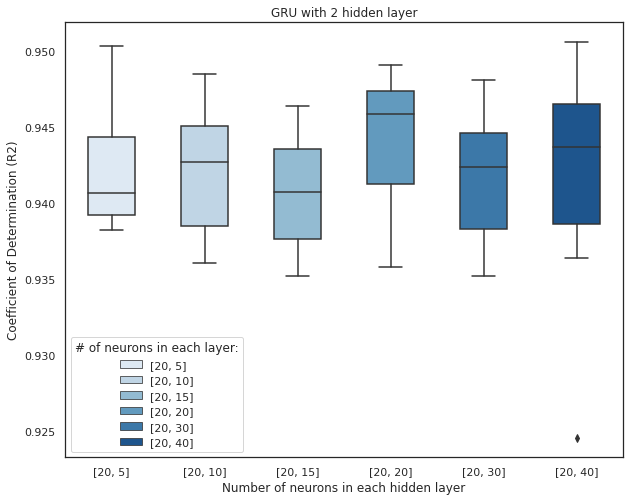

In [24]:
raw_data = pd.read_csv('/content/export_dataframe-LSTM-2hidden.csv', header=0,
                      na_values = "?", comment='#', encoding='UTF-8',
                      sep=",", skipinitialspace=True)

dataMetrics = raw_data.copy()
dataMetrics['Number of neurons'] = dataMetrics['Number of neurons'].apply(lambda x: '[20, '+str(x)[:-2]+']')
dataMetrics.rename(columns={'Number of neurons': '# of neurons in each layer:'}, inplace = True)
#dataMetrics

fig, ax=plt.subplots()
sns.set(rc={'figure.figsize':(10,8)})
ax.legend(loc="best")
fig.set_edgecolor('g')
ax.set_facecolor("white")
sns.set_theme(style="white")
axx = sns.boxplot(x='# of neurons in each layer:', palette="Blues",
                 y="r2", color=".25",
                 dodge=False,
                 width=.5,
                 hue='# of neurons in each layer:', 
                 data=dataMetrics, ax=ax).set(
            title='LSTM with 2 hidden layer',
            xlabel='Number of neurons in each hidden layer',
            ylabel='Coefficient of Determination (R2)')
                 
plt.show()
fig.savefig('lstm2.pdf')